#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * features.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [5]:
data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

In [6]:
data01_train.drop(columns = 'subject', inplace = True)
data01_test.drop(columns = 'subject', inplace =  True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [7]:
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [8]:
data01_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [9]:
data01_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [10]:
features.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [11]:
features.describe()

,sensor,agg,axis,feature_name
count,561,561,436,561
unique,18,27,62,561
top,fBodyGyro,bandsEnergy(),X,tBodyAcc-mean()-X
freq,79,126,76,1


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sensor        561 non-null    object
 1   agg           561 non-null    object
 2   axis          436 non-null    object
 3   feature_name  561 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [13]:
data01_train['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


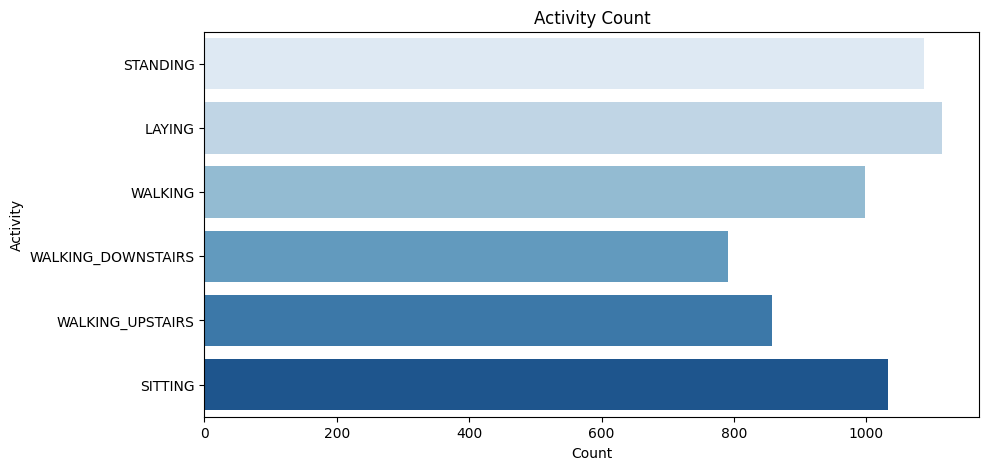

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(y='Activity', data=data01_train, hue = 'Activity', palette='Blues')
plt.title('Activity Count')
plt.ylabel('Activity')
plt.xlabel('Count')
plt.show()

<ipython-input-15-ba91b871f354>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratio.values, y=ratio.index, palette='Blues', ax=axes[0])


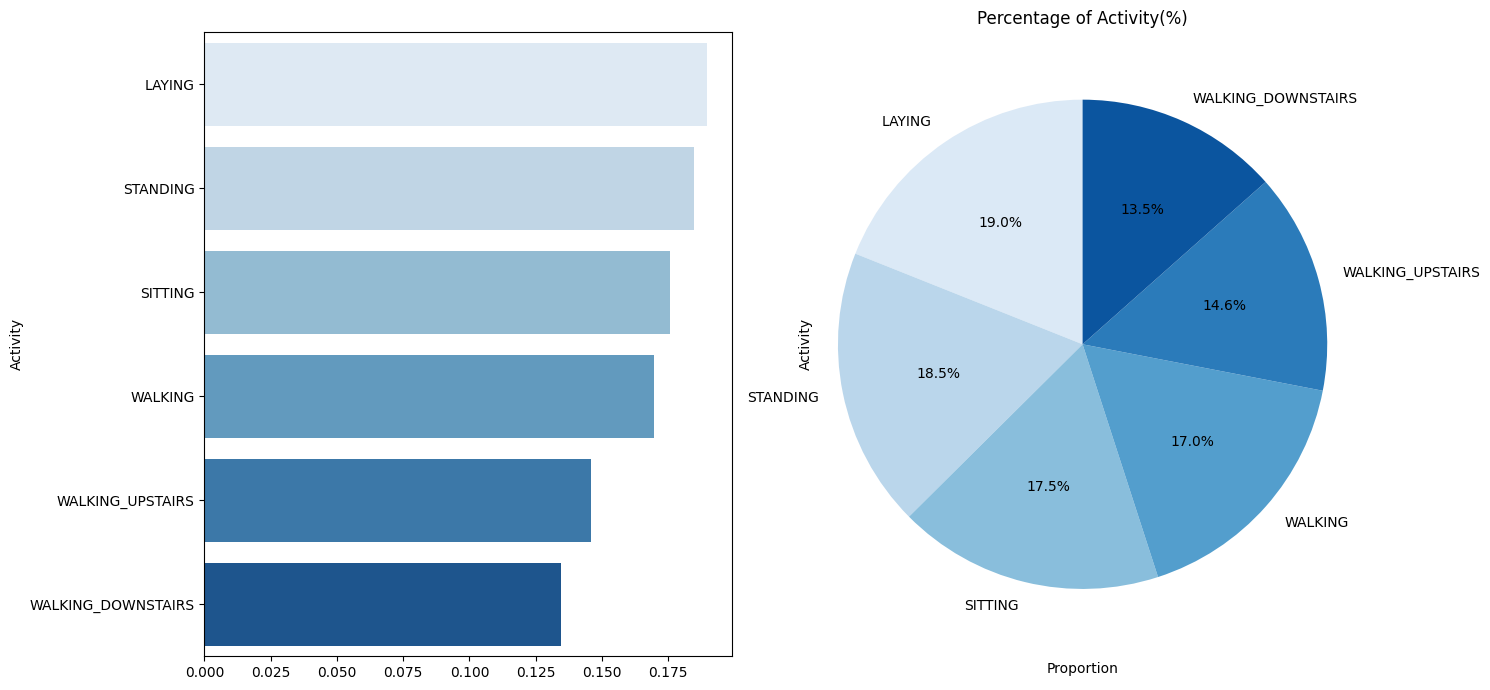

In [15]:
ratio = data01_train['Activity'].value_counts(normalize=True)
activity_percentage = ratio * 100

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

sns.barplot(x=ratio.values, y=ratio.index, palette='Blues', ax=axes[0])
plt.title('Proportion of Activity')
plt.ylabel('Activity')
plt.xlabel('Proportion')

colors = sns.color_palette('Blues', len(activity_percentage))
axes[1].pie(activity_percentage, labels=activity_percentage.index, autopct='%1.1f%%',
            startangle=90,colors=colors)
axes[1].set_title('Percentage of Activity(%)')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [16]:
target = 'Activity'
x = data01_train.drop(columns = target)
y = data01_train.loc[:, target]

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

#### 2) 모델링

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [20]:
y_pred = model.predict(x_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[221   0   0   0   0   1]
 [  0 192   6   0   0   0]
 [  0   9 226   0   0   0]
 [  0   0   0 187   3   2]
 [  0   0   0   1 154   1]
 [  0   0   0   1   1 172]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       222
           SITTING       0.96      0.97      0.96       198
          STANDING       0.97      0.96      0.97       235
           WALKING       0.99      0.97      0.98       192
WALKING_DOWNSTAIRS       0.97      0.99      0.98       156
  WALKING_UPSTAIRS       0.98      0.99      0.98       174

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



#### 3) 변수 중요도 추출

In [21]:
# 상위 5개 및 하위 5개 특성 선택
importances = model.feature_importances_
indices = np.argsort(importances)

# 상위 5개 인덱스
top_indices = indices[-5:]

# 하위 5개 인덱스
bottom_indices = indices[:5]

# 상위와 하위를 합치기
selected_indices = np.concatenate([top_indices, bottom_indices])
selected_importances = importances[selected_indices]
selected_features = x_train.columns[selected_indices]

# 결과를 데이터프레임으로 만들기
results_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': selected_importances
})

# 데이터프레임 정렬 (상위 먼저)
results_df = results_df.sort_values(by='Importance', ascending=False)

# 결과 출력
display(results_df)

,Feature,Importance
4,tGravityAcc-min()-X,0.031863
3,tGravityAcc-min()-Y,0.031612
2,"angle(Y,gravityMean)",0.028533
1,tGravityAcc-mean()-Y,0.025596
0,tGravityAcc-energy()-X,0.025440
9,"fBodyAccJerk-bandsEnergy()-33,40",0.000099
8,"tBodyAcc-arCoeff()-Y,2",0.000088
7,"fBodyAccJerk-bandsEnergy()-57,64.1",0.000087
6,"angle(tBodyAccMean,gravity)",0.000082
5,"fBodyAcc-bandsEnergy()-57,64.1",0.000075


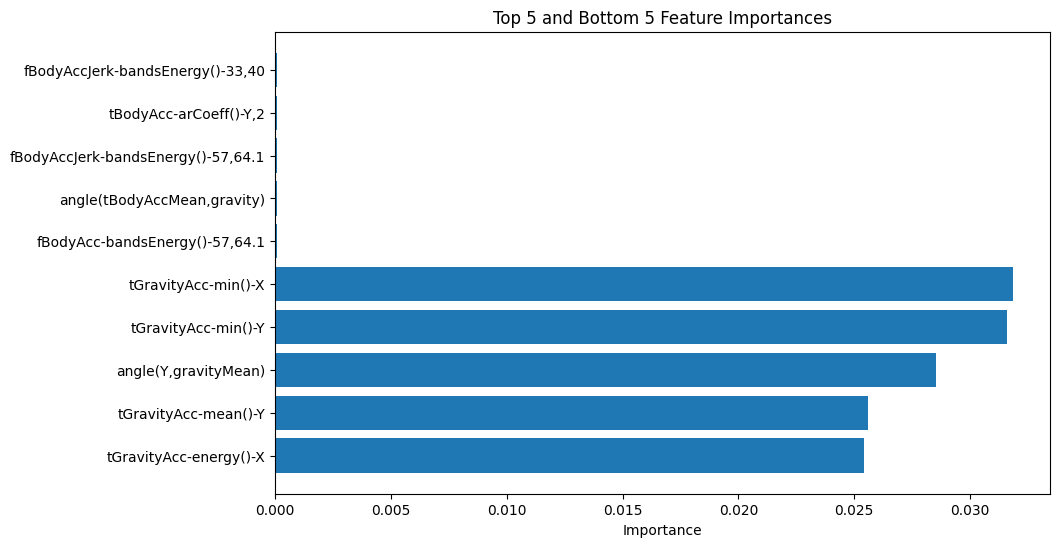

In [22]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(selected_features, selected_importances)
plt.title('Top 5 and Bottom 5 Feature Importances')
plt.xlabel('Importance')
plt.show()

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [75]:
top_cols = ['tGravityAcc-mean()-X', 'tGravityAcc-min()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-energy()-X', 'tGravityAcc-min()-Y']
bottom_cols = ['fBodyAcc-iqr()-Y', 'fBodyAccJerk-bandsEnergy()-57,64.1',
               'fBodyAcc-bandsEnergy()-49,64', 'fBodyAccJerk-entropy()-Y', 'fBodyAcc-bandsEnergy()-33,48']

#### 2) 상위 5개 변수에 대한 분석

In [76]:
def kdeplot_top(n, y_limit=None):
  plt.figure(figsize=(8,5))
  colors = sns.color_palette('Set1', 6)
  sns.kdeplot(data=data01_train, x=top_cols[n], hue='Activity', common_norm=False, fill=True, palette=colors)

  plt.title(f'Analysis of the Top 5 Variables - {top_cols[n]}')
  plt.xlabel(top_cols[n])
  plt.ylabel('Density')

  if y_limit:
    plt.ylim(top=y_limit)

  plt.show()

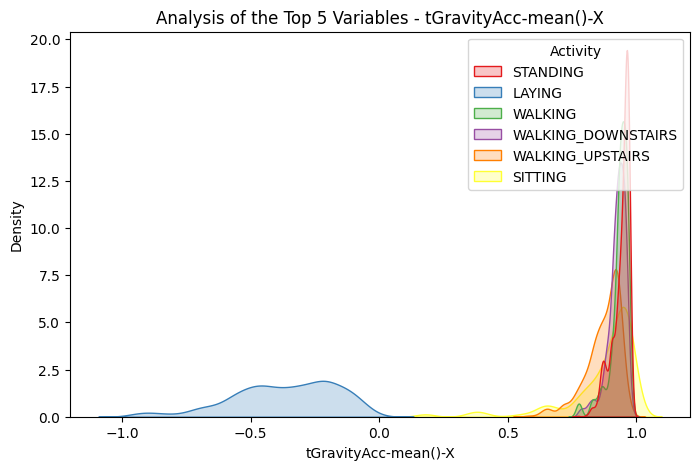

In [77]:
kdeplot_top(0)

1. tGravityAcc-min()-X: 시간 영역(time domain)에서 중력 가속도(tGravityAcc)의 X축 최솟값.
중력 가속도는 움직임보다는 자세와 관련된 정보일 가능성이 큽니다. 즉, 정적인 활동(서기, 앉기 등)과 동적인 활동(걷기 등)에서 특징적으로 달라질 수 있습니다.

2. 정적인 활동 (STANDING, SITTING, LAYING)

*   LAYING은 0 근처에 중심을 두고, 넓게 퍼진 분포를 가집니다.
→ 이는 누워 있는 동안 중력 가속도가 주로 일정하고 작은 값이라는 것을 의미합니다.
*   STANDING과 SITTING은 1 근처에서 피크가 나타납니다.
→ 이는 서거나 앉아 있을 때 중력 가속도가 X축 방향으로 크게 작용함을 의미합니다.

3.  동적인 활동 (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS)

*   이 세 활동은 분포가 서로 겹쳐지며 넓게 퍼짐을 볼 수 있습니다.
*   0~1 사이에서 주로 분포하고, 값의 변화가 더 크다는 것을 의미합니다.
→ 이는 걷거나 계단을 오르내릴 때 X축 중력 가속도의 최소값이 다양하게 나타난다는 것을 의미합니다.


3. 활용 방안 및 결론
* 이 변수는 정적 활동(서기, 앉기, 눕기)과 동적 활동(걷기 등)을 구분하는 데 유용해 보입니다.
* 그러나 동적인 활동(WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS) 사이의 구분은 어려울 수 있습니다.
→ 모델 학습 시에는 이 변수를 포함하되, 동적인 활동을 명확히 구분할 수 있는 다른 변수를 추가적으로 사용하는 것이 좋겠습니다.



4. 이 그래프를 통해 활동의 유형에 따른 가속도 분포의 차이를 이해할 수 있으며, 특히 정적인 활동과 동적인 활동을 구분하는 데 의미 있는 정보를 제공한다는 점을 알 수 있습니다.


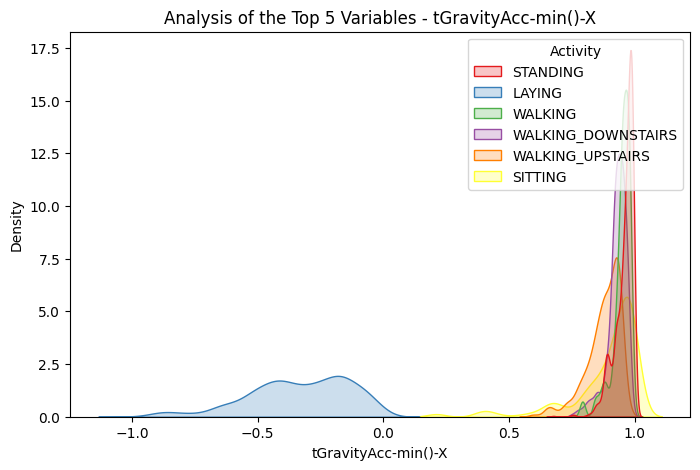

In [78]:
kdeplot_top(1)

1. x 변수 : tGravityAcc-min()-X
  - X축에서 작용하는 중력 가속도의 최소값
  - 즉, X축이 중력 방향과 반대되는 방향으로 가장 많이 기울어졌을 때의 가속도
  - 스마트폰이 어떻게 기울어져 있는지 판단하는 역할
2. 해석   
(1) 1에 가까운 값
  - 중력 가속도가 X축에서 거의 작용하지 않음
  - 스마트폰이 세로로 세워져 있거나 X축이 수평에 가까운 상태 : 상쇄
  - ex.사용자가 서있거나 않아있을 때  

  (2) -1에 가까운 값
  - 중력 가속도가 X축에서 완전히 반대 방향으로 작용
  - 스마트폰이 중력 방향과 반대 방향일 때
  - ex.옆으로 돌아 누워 있는 상태  

  (3) 0에 가까운 값
  - 중력 가속도가 x축에 거의 작용 x
  - 스마트폰이 기울어져 있는 상태

  (4) 정리
  - Laying은 옆으로 돌아누웠을 때는 -1, 정면으로 누웠을 때는 0에 가까운 분포 / 나머지 자세에서는 보통 스마트폰을 세워서 보거나 기울여서 보기 때문에 0.5~1.0 사이의 분포

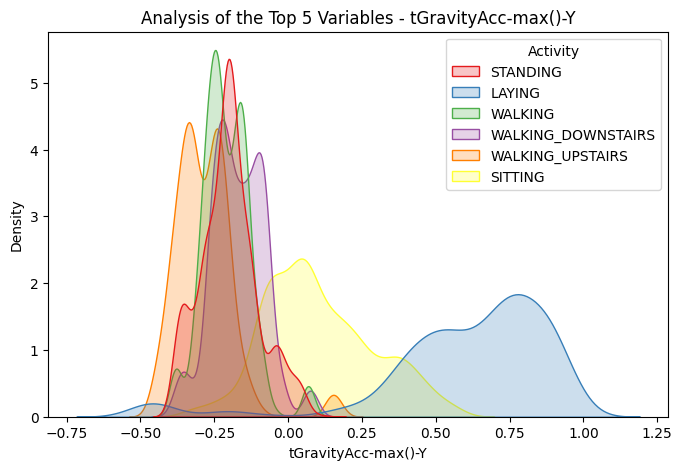

In [79]:
kdeplot_top(2)

- 누워서 스마트폰을 보는 경우 자세에 따라 기울기가 달라질 수 있어서 Laying이 넓게 분포

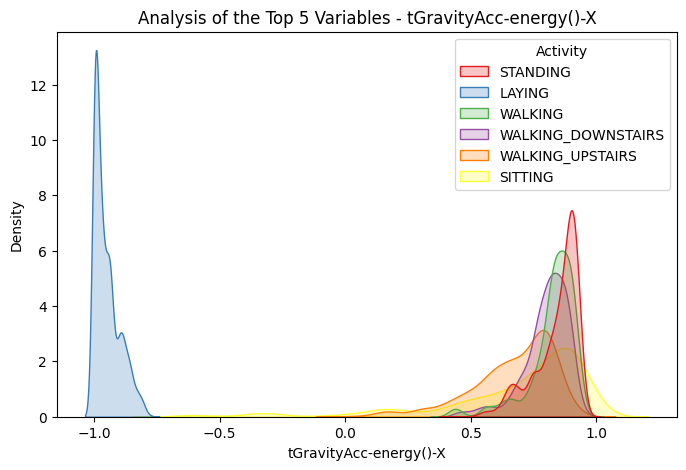

In [28]:
kdeplot_top(3)

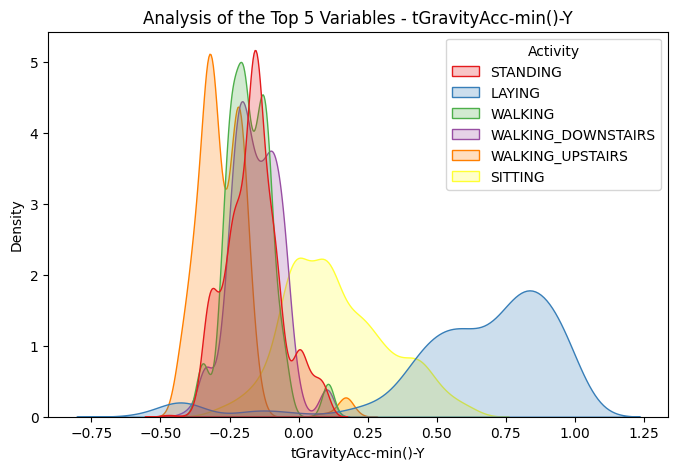

In [29]:
kdeplot_top(4)

#### 3) 하위 5개 변수에 대한 분석

In [80]:
def kdeplot_bottom(n, y_limit=None):
  plt.figure(figsize=(8,5))
  colors = sns.color_palette('Set1', 6)
  sns.kdeplot(data=data01_train, x=bottom_cols[n], hue='Activity', common_norm=False, fill=True, palette=colors)

  plt.title(f'Analysis of the Bottom 5 Variables - {top_cols[n]}')
  plt.xlabel(bottom_cols[n])
  plt.ylabel('Density')

  if y_limit:
    plt.ylim(top=y_limit)

  plt.show()

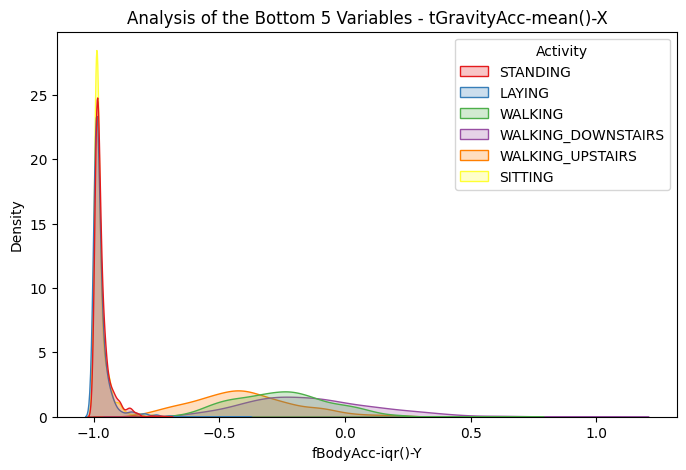

In [81]:
kdeplot_bottom(0)

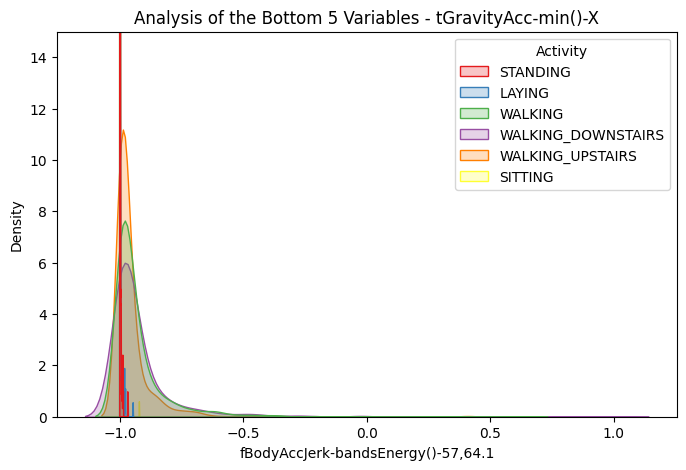

In [85]:
kdeplot_bottom(1,15)

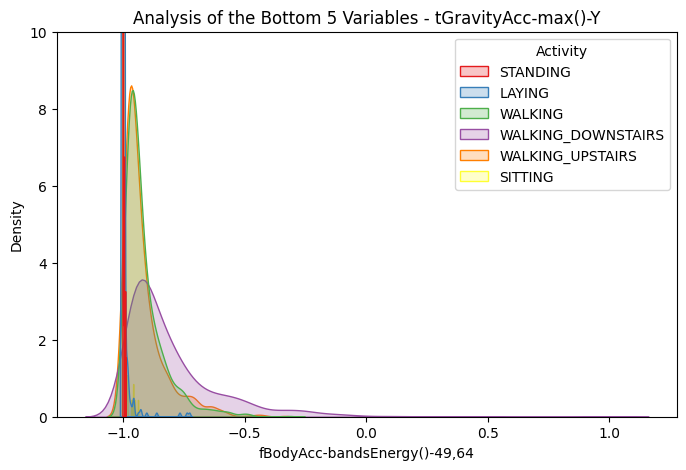

In [88]:
kdeplot_bottom(2,10)

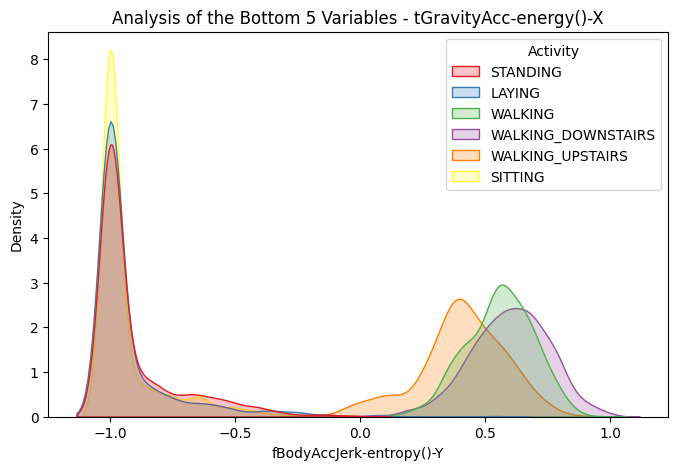

In [34]:
kdeplot_bottom(3)

- 정적 상태 3가지 변수가 -1 부근에 모여있고, 동적 상태 3가지 변수가 0~1 사ㅏ이에 모여있는 것으로 보아 중력가속도(에너지)는 정적/동적 상태 구분에 좋은 역할을 할 것으로 보임

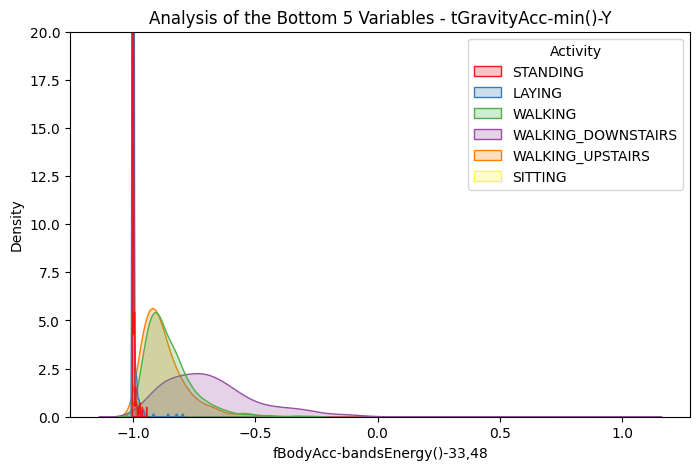

In [91]:
kdeplot_bottom(4,20)

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [36]:
data01_train['is_dynamic'] = data01_train['Activity'].replace({
    'STANDING': 0,
    'SITTING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 1})

<ipython-input-36-41e9776c8137>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data01_train['is_dynamic'] = data01_train['Activity'].replace({


#### 2) 기본모델 생성

In [37]:
target = 'is_dynamic'
x = data01_train.drop(columns = ['Activity', 'is_dynamic'])
y = data01_train[target]

In [38]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

In [39]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [40]:
y_pred = model.predict(x_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[653   2]
 [  0 522]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [41]:
# 상위 5개 및 하위 5개 특성 선택
importances = model.feature_importances_
indices = np.argsort(importances)

# 상위 5개 인덱스
top_indices = indices[-5:]

# 하위 5개 인덱스
bottom_indices = indices[:5]

# 상위와 하위를 합치기
selected_indices = np.concatenate([top_indices, bottom_indices])
selected_importances = importances[selected_indices]
selected_features = x_train.columns[selected_indices]

# 결과를 데이터프레임으로 만들기
results_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': selected_importances
})

# 데이터프레임 정렬 (상위 먼저)
results_df = results_df.sort_values(by='Importance', ascending=False)

# 결과 출력
display(results_df)

,Feature,Importance
4,fBodyAccJerk-max()-X,0.080060
3,fBodyAccJerk-mean()-X,0.050008
2,fBodyAccJerk-mad()-X,0.050008
1,fBodyGyro-sma(),0.049795
0,tBodyAccJerk-std()-X,0.039940
5,tBodyAcc-mean()-X,0.000000
6,fBodyAccJerk-meanFreq()-X,0.000000
7,fBodyAccJerk-maxInds-Z,0.000000
8,fBodyAccJerk-maxInds-X,0.000000
9,fBodyAccJerk-entropy()-Z,0.000000


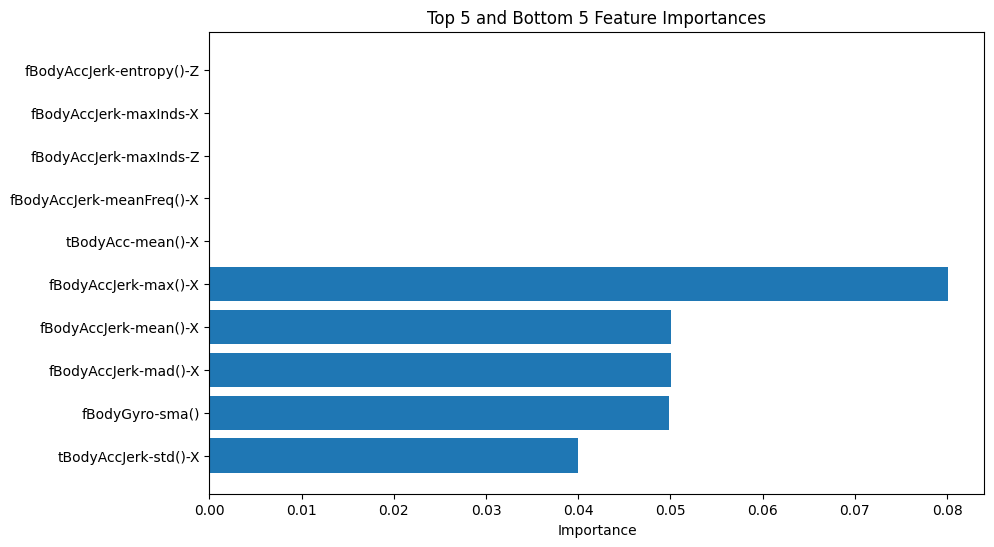

In [42]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(selected_features, selected_importances)
plt.title('Top 5 and Bottom 5 Feature Importances')
plt.xlabel('Importance')
plt.show()

#### 3) 변수중요도 상위 5개 분석

In [50]:
from re import X
top_cols = ['fBodyAccJerk-bandsEnergy()-1,16', 'fBodyAccJerk-energy()-X', 'tBodyAccJerk-std()-X',
            'tBodyAccJerk-mad()-X', 'fBodyAccJerk-bandsEnergy()-1,8']

In [68]:
def kdeplot_top2(n, y_limit=None):
  plt.figure(figsize=(8,5))
  sns.kdeplot(data=data01_train, x=top_cols[n], hue='is_dynamic', common_norm=False, fill=True, palette='Blues')

  plt.title(f'Analysis of the Top 5 Variables - {top_cols[n]}')
  plt.xlabel(top_cols[n])
  plt.ylabel('Density')

  if y_limit:
        plt.ylim(top=y_limit)

  plt.show()

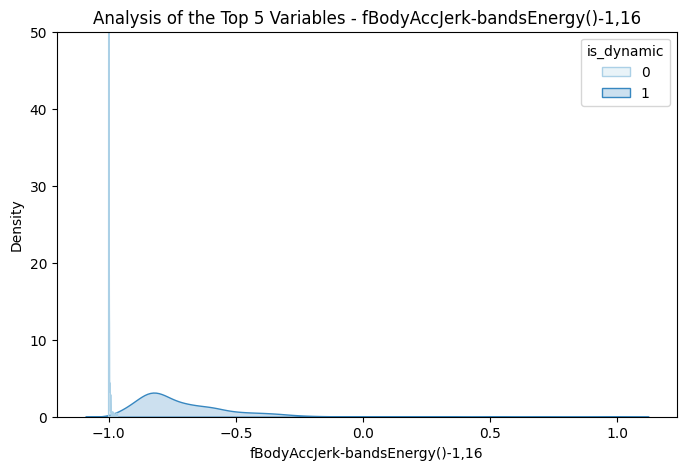

In [72]:
# 상위 5개
kdeplot_top2(0, 50)

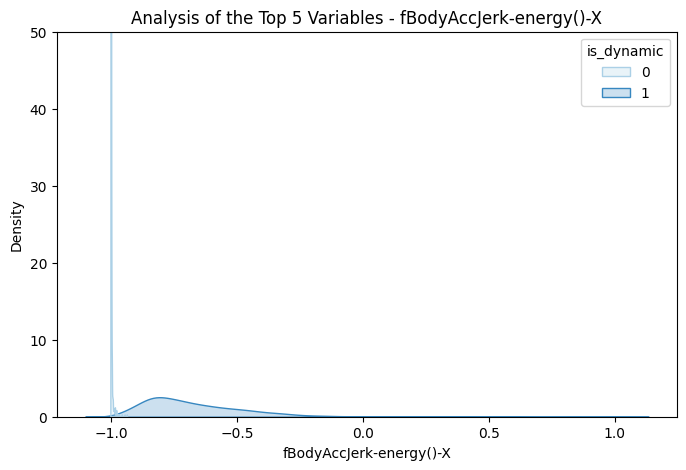

In [73]:
kdeplot_top2(1, 50)

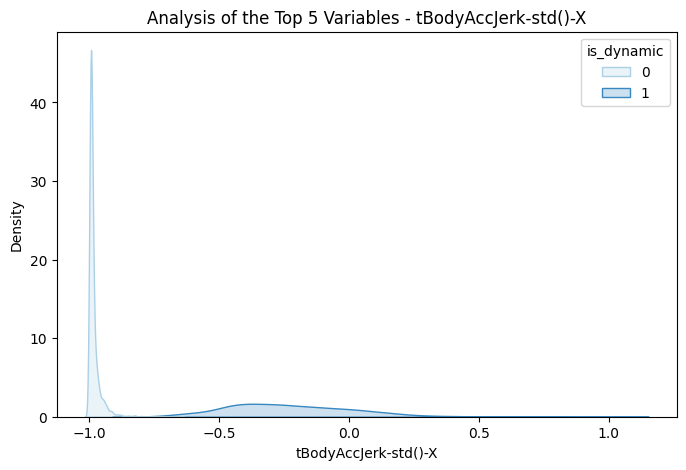

In [59]:
kdeplot_top2(2)

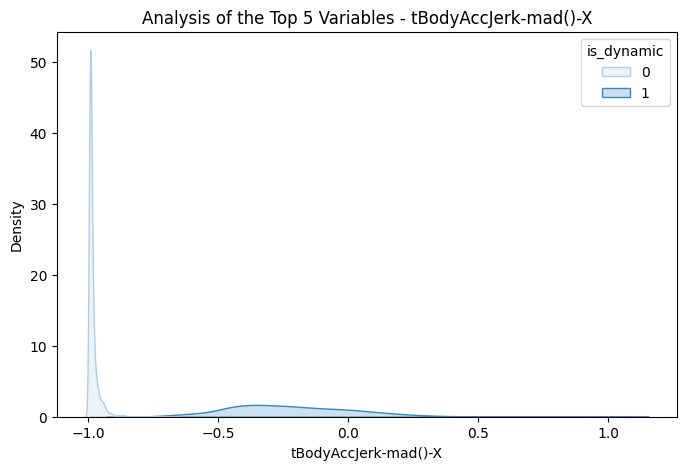

In [60]:
kdeplot_top2(3)

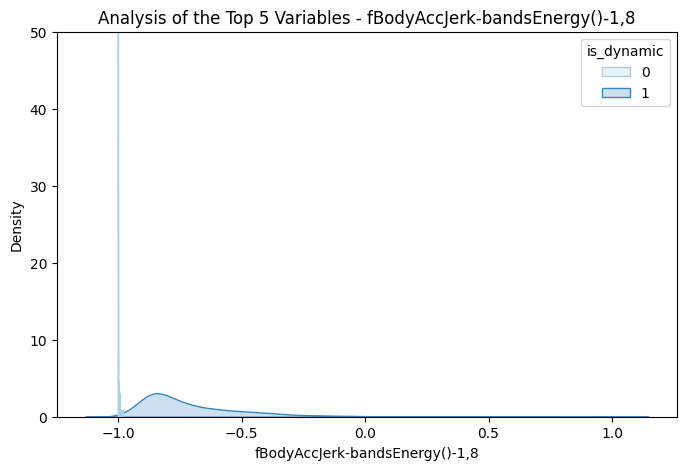

In [74]:
kdeplot_top2(4, y_limit=50)